Work realised by Aurélien DEVILLARD and Alice MONFRONT, AMSE Students, in April 2021.

# Importation of modules

In [142]:
import glob
import os
import pathlib
import datetime
import pickle
import yaml

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf


from PIL import Image
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from sklearn import svm

## open Yaml file

In [143]:
with open('parameters.yaml') as yaml_data:
    params = yaml.safe_load(yaml_data)


TRAINING_CSV_PATH = params[0]['TRAINING_CSV_PATH']
SAVE_MODELS_PATH = params[1]['SAVE_MODELS_PATH']
IMAGE_WIDTH = params[2]['IMAGE_WIDTH']
IMAGE_HEIGHT = params[3]['IMAGE_HEIGHT']

# Reading image files

In [2]:
!curl -O https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0  263M    0  240k    0     0   415k      0  0:10:49 --:--:--  0:10:49  415k
  1  263M    1 4256k    0     0  2700k      0  0:01:39  0:00:01  0:01:38 2700k
  3  263M    3 8160k    0     0  3164k      0  0:01:25  0:00:02  0:01:23 3164k
  4  263M    4 11.7M    0     0  3351k      0  0:01:20  0:00:03  0:01:17 3351k
  5  263M    5 14.1M    0     0  3174k      0  0:01:25  0:00:04  0:01:21 3174k
  6  263M    6 17.2M    0     0  3170k      0  0:01:25  0:00:05  0:01:20 3488k
  7  263M    7 20.7M    0     0  3237k      0  0:01:23  0:00:06  0:01:17 3407k
  8  263M    8 21.3M    0     0  2783k      0  0:01:36  0:00:07  0:01:29 2597k
  8  263M    8 23.4M    0     0  2782k      0  0:01:36  0:00:08  0:01:28 2377k
 10  263M   10 27.8M    0     0  2974k      0  0:01

In [3]:
!curl -O https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip
!curl -O https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_GT.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0 84.8M    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0 84.8M    0  848k    0     0   670k      0  0:02:09  0:00:01  0:02:08  670k
  2 84.8M    2 2592k    0     0  1128k      0  0:01:16  0:00:02  0:01:14 1128k
  5 84.8M    5 5056k    0     0  1548k      0  0:00:56  0:00:03  0:00:53 1548k
 10 84.8M   10 9200k    0     0  2157k      0  0:00:40  0:00:04  0:00:36 2157k
 13 84.8M   13 11.2M    0     0  2164k      0  0:00:40  0:00:05  0:00:35 2295k
 15 84.8M   15 13.3M    0     0  2185k      0  0:00:39  0:00:06  0:00:33 2569k
 19 84.8M   19 16.2M    0     0  2288k      0  0:00:37  0:00:07  0:00:30 2823k
 20 84.8M   20 17.6M    0     0  2187k      0  0:00:39  0:00:08  0:00:31 2604k
 24 84.8M   24 20.7M    0     0  2291k      0  0:00

In [4]:
#!unzip -q GTSRB_Final_Training_Images.zip

In [6]:
os.path.dirname(TRAINING_CSV_PATH)

'D:/Documents/Cours/AMSE/M2_S2/hands-on-2021/data/raw/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images/*'

## Functions creation

In [81]:
def build_images_database(path):
    """Build a pandas DataFrame with all images information.
    
    Parameters
    ----------
    path: path pattern to read csv files containing images information
    
    Returns
    -------
    A pandas DataFrame with one line per image
    """
    df_list = []
    for filename in glob.glob(path):
        df = pd.read_csv(filename, sep=';')
        df['path'] = os.path.dirname(filename) + '/' + df['Filename']
        df_list.append(df)
    
    return pd.concat(df_list, ignore_index=True)


def build_images_list(filename_list, boxes_list=None):
    """Build a list of images as Numpy array
    
    Parameters
    ----------
    filename_list: list of images filenames
    boxes_list: optional list of boxes for clipping within images. Boxes are 4-tuples (x1, y1, x2, y2).
    
    Returns
    -------
    A list of images as Numpy arrays
    
    """
    
    # If no boxes_list is given, generate a fake boxes list with None boxes
    # image.resize will take full size images if argument box == None
    if boxes_list is None:
        boxes_list = [None] * len(filename_list)
        
    assert len(filename_list) == len(boxes_list), "filenames and boxes lists must have the same length"
    
    images_list = []
    for (filename, image_box) in zip(filename_list, boxes_list):
        image = Image.open(filename)
        image = image.resize((IMAGE_WIDTH, IMAGE_HEIGHT), box=image_box) # box argument clips image to (x1, y1, x2, y2)
        image = np.array(image)
        images_list.append(image)
        
    return images_list


def build_classes_array(df, col_name='ClassId'):
    """Build a vector (numpy array) of classes
    
    Parameters
    ----------
    df: pandas DataFrame with a column containing classes id
    
    Returns
    -------
    Numpy array with image classes
    
    """
    return df[col_name].values

def save_classifier(model, basename):
  """Save to H5 format a TF model with a timestamp, for NN model

  Paramaters
  ----------
  model: trained tf model
  basename: basename including path to use for filename

  Returns
  -------
  Saved model in .h5 format
  """
  model.save(SAVE_MODELS_PATH +'{}_{}.h5'.format(basename, datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')))
  return

def save_classifier_SVM(model, basename):
  """ Save to pickle format a TF model with a timestamp, for SVM models

  Parameters
  ----------
  model: trained SVM model
  basename: basename including path to use for filename

  Returns
  -------
  Saves a trained SVM model in pickle format
  """
  with open(SAVE_MODELS_PATH + '{}_{}.pickle'.format(basename, datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')), 'wb') as f:
    pickle.dump(model, f)
  return


def load_model_SVM(model_name, basename):
    """ Save to H5 format a TF model with a timestamp, for SVM models
    Parameters
    ----------
    model_name: name of the model once loaded
    basename: basename of the filename to use

    Returns
    -------
    Loads a trained model
    """
    model_name = open(SAVE_MODELS_PATH + basename, 'rb')
    model_name = pickle.load(model_name)
    return

In [8]:
images_df = build_images_database(TRAINING_CSV_PATH)
images_df.head()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,path
0,00000_00000.ppm,29,30,5,6,24,25,0,D:/Documents/Cours/AMSE/M2_S2/hands-on-2021/da...
1,00000_00001.ppm,30,30,5,5,25,25,0,D:/Documents/Cours/AMSE/M2_S2/hands-on-2021/da...
2,00000_00002.ppm,30,30,5,5,25,25,0,D:/Documents/Cours/AMSE/M2_S2/hands-on-2021/da...
3,00000_00003.ppm,31,31,5,5,26,26,0,D:/Documents/Cours/AMSE/M2_S2/hands-on-2021/da...
4,00000_00004.ppm,30,32,5,6,25,26,0,D:/Documents/Cours/AMSE/M2_S2/hands-on-2021/da...


## Exploration of the data with a subset of 200 images

In [9]:
# Reading only 200 images for the moment
images_list = build_images_list(images_df.head(200)['path'].values,
                                images_df.head(200).apply(lambda r: (r['Roi.X1'], r['Roi.Y1'], r['Roi.X2'], r['Roi.Y2']),
                                                          axis=1).values)

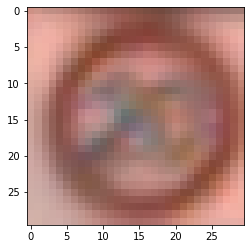

In [10]:
plt.imshow(images_list[90])

In [11]:
build_classes_array(images_df)

array([ 0,  0,  0, ..., 42, 42, 42], dtype=int64)

In [12]:
images_df['ClassId'].value_counts()

2     2250
1     2220
13    2160
12    2100
38    2070
10    2010
4     1980
5     1860
25    1500
9     1470
7     1440
8     1410
3     1410
11    1320
35    1200
18    1200
17    1110
31     780
14     780
33     689
15     630
26     600
28     540
23     510
30     450
16     420
34     420
6      420
22     390
36     390
40     360
20     360
21     330
39     300
29     270
24     270
27     240
42     240
32     240
41     240
19     210
37     210
0      210
Name: ClassId, dtype: int64

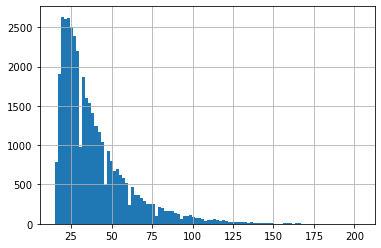

In [13]:
(images_df['Roi.X2'] - images_df['Roi.X1']).hist(bins=100);

In [14]:
(images_df['Roi.Y2'] - images_df['Roi.Y1']).median()

32.0

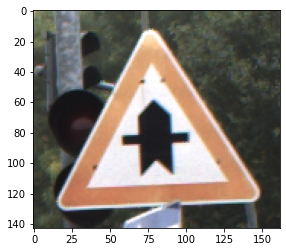

In [15]:
plt.imshow(Image.open(images_df.query('Width == 162')['path'].values[0]))

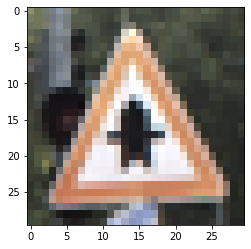

In [16]:
plt.imshow(Image.open(images_df.query('Width == 162')['path'].values[0]).resize((30, 30)))

In [17]:
images_df.head(1)

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,path
0,00000_00000.ppm,29,30,5,6,24,25,0,D:/Documents/Cours/AMSE/M2_S2/hands-on-2021/da...


# Training the models

In [19]:
print(tf.__version__)

2.3.0


#### Take a sample to test the code

In [21]:
images_df.shape

(39209, 9)

In [22]:
#N = 10_000
N = None # Take all

if N is None:
  images_list = build_images_list(images_df['path'].values,
                                  images_df.apply(lambda r: (r['Roi.X1'], r['Roi.Y1'], r['Roi.X2'], r['Roi.Y2']),
                                                        axis=1).values)
  data = np.array(images_list)
  labels = build_classes_array(images_df)
else:
  images_list = build_images_list(images_df.head(N)['path'].values,
                                  images_df.head(N).apply(lambda r: (r['Roi.X1'], r['Roi.Y1'], r['Roi.X2'], r['Roi.Y2']),
                                                            axis=1).values)
  data = np.array(images_list)
  labels = build_classes_array(images_df)[:N]

print(data.shape, labels.shape)

(39209, 30, 30, 3) (39209,)


In [23]:
#Splitting training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(31367, 30, 30, 3) (7842, 30, 30, 3) (31367,) (7842,)


In [24]:
#Converting the labels into one hot encoding
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
print(y_train.shape, y_test.shape)

(31367, 43) (7842, 43)


## Neural Network model

### Compilation of the model

In [25]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(43, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 64)          18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 64)          0

In [26]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(31367, 30, 30, 3) (7842, 30, 30, 3) (31367, 43) (7842, 43)


In [27]:
%%time
epochs = 15
history = model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_test, y_test))

Epoch 1/15
981/981 [==============================] - 96s 98ms/step - loss: 2.0429 - accuracy: 0.5041 - val_loss: 0.4077 - val_accuracy: 0.8944
Epoch 2/15
981/981 [==============================] - 84s 86ms/step - loss: 0.5738 - accuracy: 0.8398 - val_loss: 0.2028 - val_accuracy: 0.9494
Epoch 3/15
981/981 [==============================] - 78s 79ms/step - loss: 0.3876 - accuracy: 0.8900 - val_loss: 0.1814 - val_accuracy: 0.9489
Epoch 4/15
981/981 [==============================] - 78s 79ms/step - loss: 0.3051 - accuracy: 0.9123 - val_loss: 0.1105 - val_accuracy: 0.9705
Epoch 5/15
981/981 [==============================] - 77s 79ms/step - loss: 0.2617 - accuracy: 0.9265 - val_loss: 0.0830 - val_accuracy: 0.9779
Epoch 6/15
981/981 [==============================] - 78s 79ms/step - loss: 0.2300 - accuracy: 0.9347 - val_loss: 0.1472 - val_accuracy: 0.9586
Epoch 7/15
981/981 [==============================] - 77s 79ms/step - loss: 0.2230 - accuracy: 0.9373 - val_loss: 0.1021 - val_accuracy:

### Plot model accurary & loss

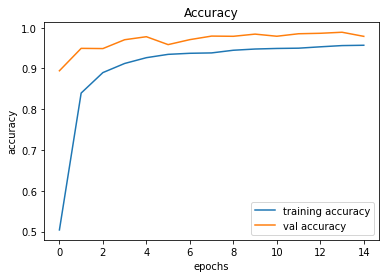

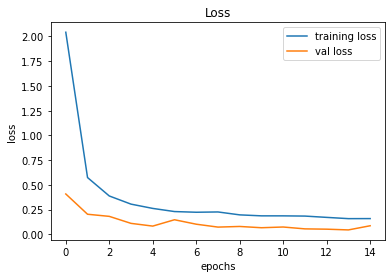

In [28]:
#plotting graphs for accuracy 
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()


### Save classifier

In [30]:
save_classifier(model, 'traffic_signs_NN')

## SVM Model

### Importation of modules

### Split dataset and reshape inputs for SVM classifier

In [32]:
X_train_SVM, X_test_SVM, y_train_SVM, y_test_SVM = train_test_split(data, labels, test_size=0.2, random_state=42)

In [33]:
X_train_SVM.shape

(31367, 30, 30, 3)

In [34]:
X_train_size = len(X_train_SVM)
X_train_SVM = X_train.reshape(X_train_size,-1)
X_train_SVM.shape

(31367, 2700)

In [35]:
X_test_size = len(X_test_SVM)
X_test_SVM = X_test.reshape(X_test_size,-1)
X_test_SVM.shape

(7842, 2700)

## Training the models

In [36]:
%%time
linear = svm.SVC(kernel='linear', C=1, decision_function_shape='ovo').fit(X_train_SVM, y_train_SVM)

Wall time: 3min 11s


In [37]:
%%time
rbf = svm.SVC(kernel='rbf', gamma=1, C=1, decision_function_shape='ovo').fit(X_train_SVM, y_train_SVM)

Wall time: 1h 6min 43s


In [38]:
%%time
poly = svm.SVC(kernel='poly', degree=3, C=1, decision_function_shape='ovo').fit(X_train_SVM, y_train_SVM)

Wall time: 11min 44s


### Save classifier

In [65]:
# Save the trained models as a pickle string.
save_classifier_SVM(linear, 'traffic_signs_SVM_linear')
save_classifier_SVM(rbf, 'traffic_signs_SVM_rbf')
save_classifier_SVM(poly, 'traffic_signs_SVM_poly')

# Load all the models

In [70]:
# Load the Neural Network model
model_NN = load_model(SAVE_MODELS_PATH + 'traffic_signs_NN_2021-03-30_23-48-11.h5')

# Load the SVM models
model_SVM_linear_picle = open(SAVE_MODELS_PATH + 'traffic_signs_SVM_linear_2021-03-31_01-35-34.pickle', 'rb')
model_SVM_linear = pickle.load(model_SVM_linear_picle)

model_SVM_poly_picle = open(SAVE_MODELS_PATH + 'traffic_signs_SVM_poly_2021-03-31_13-47-41.pickle', 'rb')
model_SVM_poly = pickle.load(model_SVM_poly_picle)
    
model_SVM_rbf_picle = open(SAVE_MODELS_PATH + 'traffic_signs_SVM_rbf_2021-03-31_01-35-35.pickle', 'rb')
model_SVM_rbf = pickle.load(model_SVM_rbf_picle)

In [71]:
model_SVM_poly

SVC(C=1, decision_function_shape='ovo', kernel='poly')

## Evaluating performance

### Extracting test data

In [73]:
#!unzip -q GTSRB_Final_Test_Images.zip

In [87]:
#!unzip GTSRB_Final_Test_GT.zip

Archive:  GTSRB_Final_Test_GT.zip
  inflating: GT-final_test.csv       


### Load test data

In [82]:
test_images_df = pd.read_csv('D:/Documents/Cours/AMSE/M2_S2/hands-on-2021/data/raw/GTSRB_Final_Test_GT/GT-final_test.csv', sep=';')
test_images_df['path'] = test_images_df['Filename'].apply(lambda x: 'D:/Documents/Cours/AMSE/M2_S2/hands-on-2021/data/raw/GTSRB_Final_Test_Images/GTSRB/Final_Test/Images/' + x)
test_images_df.tail()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,path
12625,12625.ppm,42,41,5,6,37,36,12,D:/Documents/Cours/AMSE/M2_S2/hands-on-2021/da...
12626,12626.ppm,50,51,6,5,45,46,33,D:/Documents/Cours/AMSE/M2_S2/hands-on-2021/da...
12627,12627.ppm,29,29,6,6,24,24,6,D:/Documents/Cours/AMSE/M2_S2/hands-on-2021/da...
12628,12628.ppm,48,49,5,6,43,44,7,D:/Documents/Cours/AMSE/M2_S2/hands-on-2021/da...
12629,12629.ppm,32,31,6,5,27,26,10,D:/Documents/Cours/AMSE/M2_S2/hands-on-2021/da...


In [83]:
test_list = build_images_list(test_images_df['path'].values,
                              test_images_df.apply(lambda r: (r['Roi.X1'], r['Roi.Y1'], r['Roi.X2'], r['Roi.Y2']),
                                                   axis=1).values)
test_data = np.array(test_list)
test_labels = build_classes_array(test_images_df)


In [84]:
print(test_data.shape, test_labels.shape)

(12630, 30, 30, 3) (12630,)


## Neural Network

In [107]:
%%time
results_nn = np.argmax(model_NN.predict(test_data), axis=-1)
(test_labels == results_nn).sum() / test_labels.shape[0]

Wall time: 4 s


0.9433887569279493

## SVM models

In [120]:
test_data_size = len(test_data)
test_data_SVM = test_data.reshape(test_data_size,-1)
test_data_SVM.shape

(12630, 2700)

In [121]:
%%time
results_SVM_linear = model_SVM_linear.predict(test_data_SVM)
(test_labels == results_SVM_linear).sum() / test_labels.shape[0]

Wall time: 3min 7s


0.8738717339667459

In [94]:
%%time
results_SVM_poly = model_SVM_poly.predict(test_data_SVM)
(test_labels == results_SVM_poly).sum() / test_labels.shape[0]

Wall time: 6min 44s


0.640221694378464

In [95]:
%%time
results_SVM_rbf = model_SVM_rbf.predict(test_data_SVM)
(test_labels == resultsSVM_rbf).sum() / test_labels.shape[0]

Wall time: 19min 56s


0.05985748218527316

## Compare actual to predicted (class-level) for Neural Network

In [108]:
accuracy_df = pd.DataFrame()
accuracy_df['actual'] = test_labels
accuracy_df['predicted'] = results_nn

In [109]:
accuracy_df.head()

,actual,predicted
0,16,16
1,1,1
2,38,38
3,33,33
4,11,11


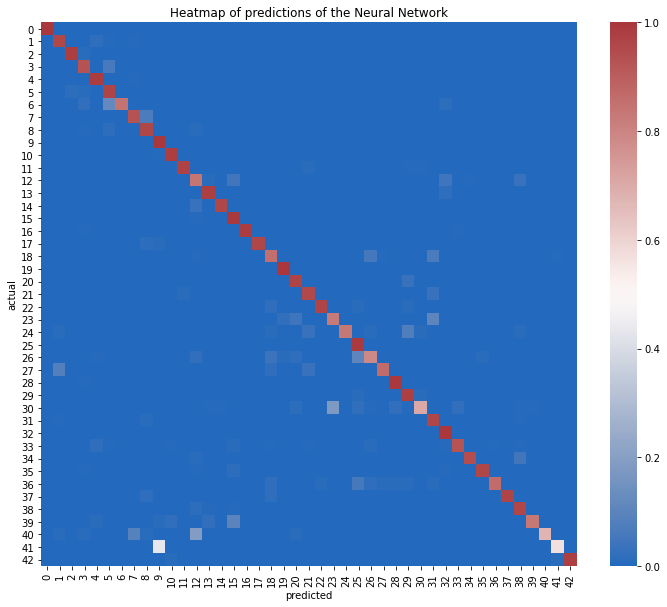

In [113]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(pd.crosstab(accuracy_df['actual'], accuracy_df['predicted'], normalize='index'),
            cmap='vlag',
            ax=ax)

ax.set_title('Heatmap of predictions of the Neural Network')
plt.show()

## Compare actual to predicted (class-level) for chosen SVM

In [122]:
results_SVM_linear

array([16,  1, 38, ...,  5,  7, 10], dtype=int64)

In [123]:
accuracy_df = pd.DataFrame()
accuracy_df['actual'] = test_labels
accuracy_df['predicted'] = results_SVM_linear

In [124]:
accuracy_df.head()

,actual,predicted
0,16,16
1,1,1
2,38,38
3,33,33
4,11,11


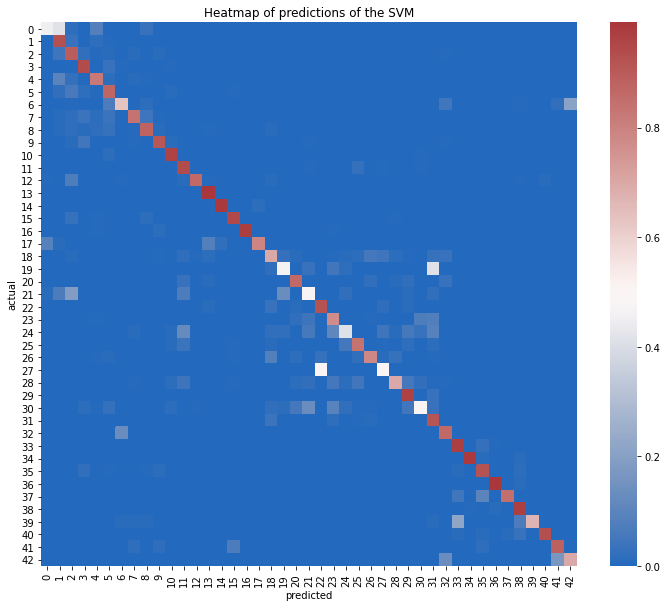

In [126]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(pd.crosstab(accuracy_df['actual'], accuracy_df['predicted'], normalize='index'),
            cmap='vlag',
            ax=ax)

ax.set_title('Heatmap of predictions of the SVM')
plt.show()

# Conclusion

We have successfully trained a Neural Network Model and a SVM model, with different activation functions (we keep the linear SVM at the end). <br>
The best model is the Neural Network with more than 92% accuracy on the test set, more efficient than the SVM model. <br>
From the heatmaps above, we see that the SVM and Neural Network don't encounter issues on the same traffic signs. As we chose to keep the Neural Network, we'll comment only some of the results associated to this model.

Concerning the traffic signs that are the most "difficult" to differentiate for the Neural network model we have : signs label 41, 40, 30 with the lowest accuracies corresponding to 40: 'Roundabout mandatory',41: 'End of no passing', 30: 'Beware of ice/snow'
<br>

Some traffic signs are sometimes misread by the algorithm, such as :
 41: 'End of no passing' which is often predicted as 9: 'No passing'. This clearly could be a problem for an autonomous car as those signs indate their contrary.
<br>
To conclude, our algortihm shows nice patterns of traffic sign recognition, especially for pictures of such a bad quality, yet it is clearly not ready for an autonomous car !! :)